In [1]:
import dlib
import cv2
import imutils
from imutils.face_utils import FaceAligner
import os
import numpy as np
import pandas as pd
import keras
import shutil
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

In [2]:
target_size = (224, 224)
# yuz tespiti yapan detektor
face_detector = dlib.get_frontal_face_detector()

# fotografta yuz var mi kontrolu
def check_detection(img):
    exact_image = False
    if type(img).__module__ == np.__name__:
        exact_image = True

    base64_img = False
    if len(img) > 11 and img[0:11] == "data:image/":
        base64_img = True


    elif not exact_image:  # image path passed as input

        if not os.path.isfile(img):
            raise ValueError("Confirm that ", img, " exists")

        img = cv2.imread(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects, scores, idx = face_detector.run(gray,1,-1)
            
    if len(rects) > 0:
        return True
    else:
        return False
    
# yuz tespit eden fonksyion
def detect_face(img):
    exact_image = False
    if type(img).__module__ == np.__name__:
        exact_image = True

    base64_img = False
    if len(img) > 11 and img[0:11] == "data:image/":
        base64_img = True

    elif not exact_image:  # image path passed as input
        if not os.path.isfile(img):
            raise ValueError("Confirm that ", img, " exists")

        img = cv2.imread(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # rects: yuz tespiti yapilan cerceve
    # scores: yuz tespiti skorlari
    # best_score_index: en yuksek skora sahip yuzun indisi
    rects, scores, idx = face_detector.run(gray,1,-1)
    best_score_index = np.argmax(scores)
    faces = []
    # tespit edilen yuzler fotograftan kirpiliyor 
    for rect in rects:
        detected_face = img[max(0, rect.top()): min(rect.bottom(), img.shape[0]),
                    max(0, rect.left()): min(rect.right(), img.shape[1])]
        
        # fotograflar 224, 224 hale getiriliyor
        detected_face = cv2.resize(detected_face, (target_size[0], target_size[1]))
        faces.append(detected_face)

    return faces[best_score_index]

# path'deki dosyalarin okunmasi icin gerekli
def absoluteFilePaths(directory):
    paths_image_list = []
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            paths_image_list.append(os.path.abspath(os.path.join(dirpath, f)))
    return paths_image_list

In [3]:
# fotojenik olmayanlara ait bilgiler okunuyor
normals_df = pd.read_csv("fairface/fairface_label_val.csv")
races = normals_df['race'].unique()
races

array(['East Asian', 'White', 'Latino_Hispanic', 'Southeast Asian',
       'Black', 'Indian', 'Middle Eastern'], dtype=object)

### Hangi kombinasyon icin model egitilecekse, ilgili path ve conditionlar duzenlenmeli

In [5]:
# hangi etnik koken ve cinsiyet icin egitim yapilacaksa ona gore ilgili path duzenlenmeli
paths = absoluteFilePaths("C:/Bitirme/beauty_dataset/White/men/contestants")

df = pd.DataFrame(paths, columns = ['Path'])
df['beauty'] = 1
df = df.rename(columns={'Path': 'file'})

# hangi etnik koken icin egitim yapilacaksa filtrelenmek icin == karsiligina yazilmali
# etnik koken etiketleri : 
# ['East Asian', 'White', 'Latino_Hispanic', 'Southeast Asian', 'Black', 'Indian', 'Middle Eastern']
normals_df = normals_df[normals_df['race'] == 'White']

# hangi cinsiyet icin egitim yapilacaksa belirtilmeli: [Male, Female]
normals_df = normals_df[normals_df['gender'] == 'Male']

normals_df = normals_df.drop(columns=['age', 'service_test'])
normals_df = normals_df.head(len(df)*5)
normals_df['beauty'] = 0

# fotojenik olmayanlarin fotograflarinin bulundugu fairface dataseti pathi verilmeli 
normals_df['file'] = normals_df['file'].apply(lambda x: 'C:/Bitirme/fairface/'+x)



In [6]:
# yuz tespiti yapilamayan fotograflar eleniyor
df['detection'] = df['file'].apply(check_detection)
df = df[df.detection == True]
df = df.drop(columns='detection')

normals_df['detection'] = normals_df['file'].apply(check_detection)
normals_df = normals_df[normals_df.detection == True]
normals_df = normals_df.drop(columns=['detection', 'gender', 'race'])
normals_df = normals_df.head(len(df))

# fotojenik ve fotojenik olmayanlara ait veriler tek bir dataframe de birlestiriliyor
union_df = pd.concat([df, normals_df]).reset_index(drop=True)

In [8]:
print(df.head(5))
print(normals_df.head(5))
print(union_df.head())

                                                file  beauty
0  C:\Bitirme\beauty_dataset\White\men\contestant...       1
1  C:\Bitirme\beauty_dataset\White\men\contestant...       1
2  C:\Bitirme\beauty_dataset\White\men\contestant...       1
3  C:\Bitirme\beauty_dataset\White\men\contestant...       1
4  C:\Bitirme\beauty_dataset\White\men\contestant...       1
                              file  beauty
2    C:/Bitirme/fairface/val/3.jpg       0
18  C:/Bitirme/fairface/val/19.jpg       0
21  C:/Bitirme/fairface/val/22.jpg       0
44  C:/Bitirme/fairface/val/45.jpg       0
46  C:/Bitirme/fairface/val/47.jpg       0
                                                file  beauty
0  C:\Bitirme\beauty_dataset\White\men\contestant...       1
1  C:\Bitirme\beauty_dataset\White\men\contestant...       1
2  C:\Bitirme\beauty_dataset\White\men\contestant...       1
3  C:\Bitirme\beauty_dataset\White\men\contestant...       1
4  C:\Bitirme\beauty_dataset\White\men\contestant...       1


In [9]:
# veriler uygun sekle getirilerek train, test olarak ayriliyor
classes = 2
target = union_df['beauty'].values
target_classes = keras.utils.to_categorical(target, classes)

features = []

for i in range(0, union_df.shape[0]):
    features.append(union_df['file'].values[i])
    
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.20)


Yoruma alinmis kisimlar, yuz tespiti yaparak kirpilmis yuzleri fotograf olarak kaydediyor, istenilirse acilabilir. Fotograflarin kaydedilmesine gerek yoksa bu kisim atlanabilir.

In [11]:
# path = 'C:/Bitirme/beauty_dataset/White/men/'
# train_path = path + 'train/'
# test_path = path + 'test/'
# normals_path = path + 'normals/'

# if not os.path.exists(normals_path):
#     os.mkdir(normals_path)
    
#     for img_path in normals_df['file'].tolist():
#         img = cv2.imread(img_path)
#         img_name = img_path.split('/')[-1]
#         cv2.imwrite(normals_path+img_name, img)
        

In [12]:
# if os.path.exists(train_path) and os.path.exists(test_path):
    # bu kisma dikkat, yanlis bi klasor silinmemesi icin train_path, test_path dogru verilmeli
#     shutil.rmtree(train_path)
#     shutil.rmtree(test_path)

# os.mkdir(path+'train')
# os.mkdir(path+'test')

# temp_list = []
# for i in train_x:
#     if '/' in i:
#         img_name = i.split('/')[-1]
#     else:
#         img_name = i.split('\\')[-1]
#     img = detect_face(i)
#     temp_list.append(img)
#     #img = cv2.imread(i)
#     #cv2.imwrite(train_path+img_name, img)

# train_x = temp_list
# temp_list2 = []
    
# for i in test_x:
#     if '/' in i:
#         img_name = i.split('/')[-1]
#     else:
#         img_name = i.split('\\')[-1]
#     img = detect_face(i)
#     temp_list2.append(img)
#     #img = cv2.imread(i)
#     #cv2.imwrite(test_path+img_name, img)

# test_x = temp_list2

In [13]:
# train_x = np.array(train_x)/255
# test_x = np.array(test_x)/255

# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y
#                                         , test_size=0.1, random_state=17)

In [14]:
# vgg-face modeli
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

model.load_weights('vgg_face_weights.h5')

for layer in model.layers[:-7]:
    layer.trainable = False


In [15]:
# fogograflarda yuz tespiti yapiliyor ve uygun egitim icin hale getiriliyor
img_pixels = [detect_face(x) for x in features]
img_pixels = np.array(img_pixels)/255

In [16]:
#del beauty_model
gc.collect()

96

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn


acc_per_fold = []
loss_per_fold = []
cm_per_fold = []

kfold = KFold(n_splits=8, shuffle=True)
fold_index = 1
for train, test in kfold.split(features, target_classes):
    print(f'\n fold:{fold_index}')
    fold_index += 1
    
    # model bastan olusturuluyor
    base_model_output = Sequential()
    base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
    base_model_output = Flatten()(base_model_output)
    base_model_output = Activation('softmax')(base_model_output)

    beauty_model = Model(inputs=model.input, outputs=base_model_output)

    sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

    beauty_model.compile(loss='categorical_crossentropy'
                      , optimizer=keras.optimizers.Adam()
                      #, optimizer = sgd
                      #, optimizer = 'sgd'   
                      , metrics=['accuracy']
                     )
    
    epochs = 10

    score = beauty_model.fit(
            img_pixels[train], target_classes[train],
            epochs=epochs
        )
    
    # test islemi
    results = beauty_model.evaluate(img_pixels[test], target_classes[test], verbose=1)
    
    # accuracy ve loss kaydediliyor
    acc_per_fold.append(results[1] * 100)
    loss_per_fold.append(results[0])
    
    # confusion matrix olusturuluyor
    predictions = beauty_model.predict(img_pixels[test])
    test_y = target_classes[test]
    prediction_classes = []; actual_classes = []
    beauty_classes = ['Beautiful', 'Normal']
    for i in range(0, predictions.shape[0]):
        prediction = np.argmax(predictions[i])
        prediction_classes.append(beauty_classes[prediction])
        actual = np.argmax(test_y[i])
        actual_classes.append(beauty_classes[actual])


    cm = confusion_matrix(actual_classes, prediction_classes)
    
    # confusion matrix kaydedildi
    cm_per_fold.append(cm)

    # k fold ile egitim icin her seferinde model bastan olusturuluyor
    # alt satirdaki 2 kod eski modelin temizlenmesi icin gerekli
    # yine de tensorflow'dan kaynakli olarak, bazen silinmeyebilir ve gpu dolabilir,
    # allocation ile ilgili bir hata alinirsa kernel bastan baslatilmali
    del beauty_model
    gc.collect()


 fold:1
Epoch 1/10
3/3 [==============================] - 2s 630ms/step - loss: 0.6145 - accuracy: 0.7931
Epoch 2/10
3/3 [==============================] - 1s 212ms/step - loss: 0.9689 - accuracy: 0.6897
Epoch 3/10
3/3 [==============================] - 1s 235ms/step - loss: 0.1141 - accuracy: 0.9540
Epoch 4/10
3/3 [==============================] - 1s 252ms/step - loss: 0.0201 - accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 1s 242ms/step - loss: 0.0265 - accuracy: 0.9770
Epoch 6/10
3/3 [==============================] - 1s 242ms/step - loss: 1.1252e-04 - accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 1s 212ms/step - loss: 2.7312e-04 - accuracy: 1.0000
Epoch 8/10
3/3 [==============================] - 1s 212ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 9/10
3/3 [==============================] - 1s 214ms/step - loss: 8.9285e-06 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 0.1304 - accuracy: 0.9231


In [18]:
# modeli kaydetmek istersek yorum satiri acilabilir
#model.save('models/white-female-new.hdf5')

In [19]:
print(f'acc_per_fold: {acc_per_fold}')
print(f'loss_per_fold: {loss_per_fold}')
print(f'average acc:{sum(acc_per_fold)/len(acc_per_fold)}')
print(f'average loss:{sum(loss_per_fold)/len(loss_per_fold)}')

[92.30769276618958, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[0.13040348887443542, 0.0005123050068505108, 1.595553953848139e-06, 0.0, 3.874292815453373e-07, 2.9802320611338473e-08, 0.0, 0.0]
average acc:99.0384615957737
average loss:0.016364725833355243


[[49  1]
 [ 0 50]]
           Beautiful  Normal
Beautiful         49       1
Normal             0      50


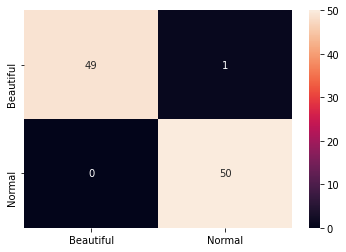

In [20]:
print(sum(cm_per_fold))
df_cm = pd.DataFrame(sum(cm_per_fold), index=beauty_classes, columns=beauty_classes)
print(df_cm)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt=".0f")